In [2]:
import wfdb
import numpy as np
import pywt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, LeakyReLU, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load ECG data with correct labels from the MIT-BIH Arrhythmia Database
def load_ecg_data_with_labels(record_numbers, segment_length=512):
    ecg_segments = []
    labels = []
    for rec_num in record_numbers:
        record = wfdb.rdrecord(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}')
        annotation = wfdb.rdann(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}', 'atr')
        
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - segment_length // 2)
            end = min(len(record.p_signal), start + segment_length)
            if end - start == segment_length:
                ecg_segments.append(record.p_signal[start:end, 0])  # Assuming MLII lead
                labels.append(annotation.symbol[i])
    
    return np.array(ecg_segments), np.array(labels)

# Load noise data from the correct directory and filenames
def load_noise_data():
    em = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\em', sampfrom=0).p_signal[:, 0]
    bw = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\bw', sampfrom=0).p_signal[:, 0]
    ma = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\ma', sampfrom=0).p_signal[:, 0]
    return em, bw, ma

# Instantiate the generator model with skip connections
def build_generator(input_shape=(512, 1)):
    inp = Input(shape=input_shape)

    # Encoder
    x1 = Conv1D(64, 15, padding='same', kernel_initializer='he_normal')(inp)
    x1 = LeakyReLU(negative_slope=0.2)(x1)

    x2 = Conv1D(128, 15, padding='same', kernel_initializer='he_normal')(x1)
    x2 = LeakyReLU(negative_slope=0.2)(x2)

    x3 = Conv1D(256, 15, padding='same', kernel_initializer='he_normal')(x2)
    x3 = LeakyReLU(negative_slope=0.2)(x3)

    x4 = Conv1D(512, 15, padding='same', kernel_initializer='he_normal')(x3)
    x4 = LeakyReLU(negative_slope=0.2)(x4)

    # Decoder with skip connections
    x5 = Conv1DTranspose(256, 15, padding='same', kernel_initializer='he_normal')(x4)
    x5 = LeakyReLU(negative_slope=0.2)(x5)
    x5 = Add()([x5, x3])

    x6 = Conv1DTranspose(128, 15, padding='same', kernel_initializer='he_normal')(x5)
    x6 = LeakyReLU(negative_slope=0.2)(x6)
    x6 = Add()([x6, x2])

    x7 = Conv1DTranspose(64, 15, padding='same', kernel_initializer='he_normal')(x6)
    x7 = LeakyReLU(negative_slope=0.2)(x7)
    x7 = Add()([x7, x1])

    out = Conv1DTranspose(1, 15, padding='same', activation='tanh')(x7)
    
    return Model(inp, out)

generator = build_generator()
generator.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Load ECG and noise data
ecg_records = [103, 105, 111, 116, 122, 205, 213, 219, 223, 230]  # Add more records as needed
ecg_segments, labels = load_ecg_data_with_labels(ecg_records)
em_noise, bw_noise, ma_noise = load_noise_data()

# Filter and map labels to integer categories
label_mapping = {'N': 0, 'V': 1, 'A': 2, 'L': 3}
mapped_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = mapped_labels != -1

ecg_segments = ecg_segments[valid_indices]
mapped_labels = mapped_labels[valid_indices]

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(mapped_labels), y=mapped_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(ecg_segments, mapped_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Extend and add noise to ECG segments
def extend_noise_signal(noise_signal, target_length):
    repeated_noise = np.tile(noise_signal, int(np.ceil(target_length / len(noise_signal))))
    return repeated_noise[:target_length]

def calculate_snr(signal, noise):
    signal_power = np.sum(np.square(signal))
    noise_power = np.sum(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_rmse(signal, denoised_signal):
    return np.sqrt(np.mean((signal - denoised_signal) ** 2))

# Extend and add noise to ECG segments using the SNR formula
def add_noise_to_segments(ecg_segments, noise_signals, target_snr_db):
    noisy_segments = []
    combined_noise_signal = np.sum([extend_noise_signal(noise, ecg_segments.shape[1]) for noise in noise_signals], axis=0)
    
    for ecg_segment in ecg_segments:
        scaling_factor = np.sqrt(np.sum(np.square(ecg_segment)) / (np.sum(np.square(combined_noise_signal)) * 10**(target_snr_db / 10)))
        scaled_noise = combined_noise_signal[:len(ecg_segment)] * scaling_factor
        noisy_segment = ecg_segment + scaled_noise
        noisy_segments.append(noisy_segment)
    return np.array(noisy_segments)

# Combine all noise types for collective training
all_noises = [em_noise, bw_noise, ma_noise]

# Set the SNR value
snr_db = 0  # You can adjust this value based on your needs

# Create noisy training, validation, and test datasets using all noise types combined
noisy_ecg_slices_train = add_noise_to_segments(X_train, all_noises, snr_db)
noisy_ecg_slices_val = add_noise_to_segments(X_val, all_noises, snr_db)
noisy_ecg_slices_test = add_noise_to_segments(X_test, all_noises, snr_db)

# Expand dimensions for training and validation
noisy_ecg_slices_train_expanded = np.expand_dims(noisy_ecg_slices_train, axis=-1)  # Expand dims for the generator
noisy_ecg_slices_val_expanded = np.expand_dims(noisy_ecg_slices_val, axis=-1)  # Expand dims for validation
clean_ecg_segments_train_expanded = np.expand_dims(X_train, axis=-1)  # Expand dims for clean ECG training data
clean_ecg_segments_val_expanded = np.expand_dims(X_val, axis=-1)

# Train the generator model on the combined noise dataset
generator.fit(noisy_ecg_slices_train_expanded, clean_ecg_segments_train_expanded, 
              epochs=10, batch_size=32, validation_data=(noisy_ecg_slices_val_expanded, clean_ecg_segments_val_expanded))

# Denoise and classify after training
denoised_ecg_slices_test = denoise_signal(generator, noisy_ecg_slices_test)

# Calculate SNR and RMSE
snr_values = [calculate_snr(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
rmse_values = [calculate_rmse(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]

features_noisy = np.array([extract_wavelet_features(slice) for slice in noisy_ecg_slices_test])
features_denoised = np.array([extract_wavelet_features(slice) for slice in denoised_ecg_slices_test])

test_labels = y_test[:len(features_noisy)]

model_noisy = classify_heartbeats(features_noisy, test_labels)
model_denoised = classify_heartbeats(features_denoised, test_labels)

# Predict the classes
predictions_noisy = model_noisy.predict(features_noisy)
predictions_denoised = model_denoised.predict(features_denoised)

# Get the unique classes present in test_labels
unique_classes = np.unique(test_labels)
class_names = [name for i, name in enumerate(['N', 'V', 'A', 'L']) if i in unique_classes]

# Evaluate accuracy for each class
report_noisy = classification_report(test_labels, predictions_noisy, target_names=class_names, output_dict=True, zero_division=0)
report_denoised = classification_report(test_labels, predictions_denoised, target_names=class_names, output_dict=True, zero_division=0)

# Store accuracy and SNR, RMSE for each class
results = {
    'snr': np.mean(snr_values),
    'rmse': np.mean(rmse_values),
    'noisy': {class_name: report_noisy[class_name]['precision'] for class_name in class_names},
    'denoised': {class_name: report_denoised[class_name]['precision'] for class_name in class_names},
}

# Output the results
print(f"Average SNR after denoising: {results['snr']:.4f} dB")
print(f"Average RMSE after denoising: {results['rmse']:.4f}")
print("Noisy data accuracies:")
for class_label, accuracy in results['noisy'].items():
    print(f"  {class_label}: {accuracy:.4f}")
print("Denoised data accuracies:")
for class_label, accuracy in results['denoised'].items():
    print(f"  {class_label}: {accuracy:.4f}")
print("\n")


Epoch 1/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 1610s 3s/step - loss: 1.0601 - val_loss: 0.3253
Epoch 2/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 1951s 4s/step - loss: 0.3460 - val_loss: 0.0509
Epoch 3/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 1835s 3s/step - loss: 0.0509 - val_loss: 0.0403
Epoch 4/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 1053s 2s/step - loss: 0.0419 - val_loss: 0.0321
Epoch 5/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 837s 2s/step - loss: 0.0347 - val_loss: 0.0320
Epoch 6/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 1115s 2s/step - loss: 0.0337 - val_loss: 0.0318
Epoch 7/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 1911s 4s/step - loss: 0.0329 - val_loss: 0.0316
Epoch 8/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 1349s 3s/step - loss: 0.0303 - val_loss: 0.0278
Epoch 9/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 641s 1s/step - loss: 0.0314 - val_loss: 0.0272
Epoch 10/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 634s 1s/step - loss: 0.0322 - val_loss: 0.0266


NameError: name 'denoise_signal' is not defined

Epoch 1/2
529/529 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - loss: 0.3783 - val_loss: 0.0523
Epoch 2/2
529/529 ━━━━━━━━━━━━━━━━━━━━ 551s 1s/step - loss: 0.0531 - val_loss: 0.0402
114/114 ━━━━━━━━━━━━━━━━━━━━ 27s 238ms/step
Average SNR after denoising: 0.4938 dB
Average RMSE after denoising: 0.1657
Noisy data accuracies:
  N: 0.9993
  V: 0.6816
  A: 0.1314
  L: 0.8896
Denoised data accuracies:
  N: 0.9945
  V: 0.5319
  A: 0.1065
  L: 0.6082




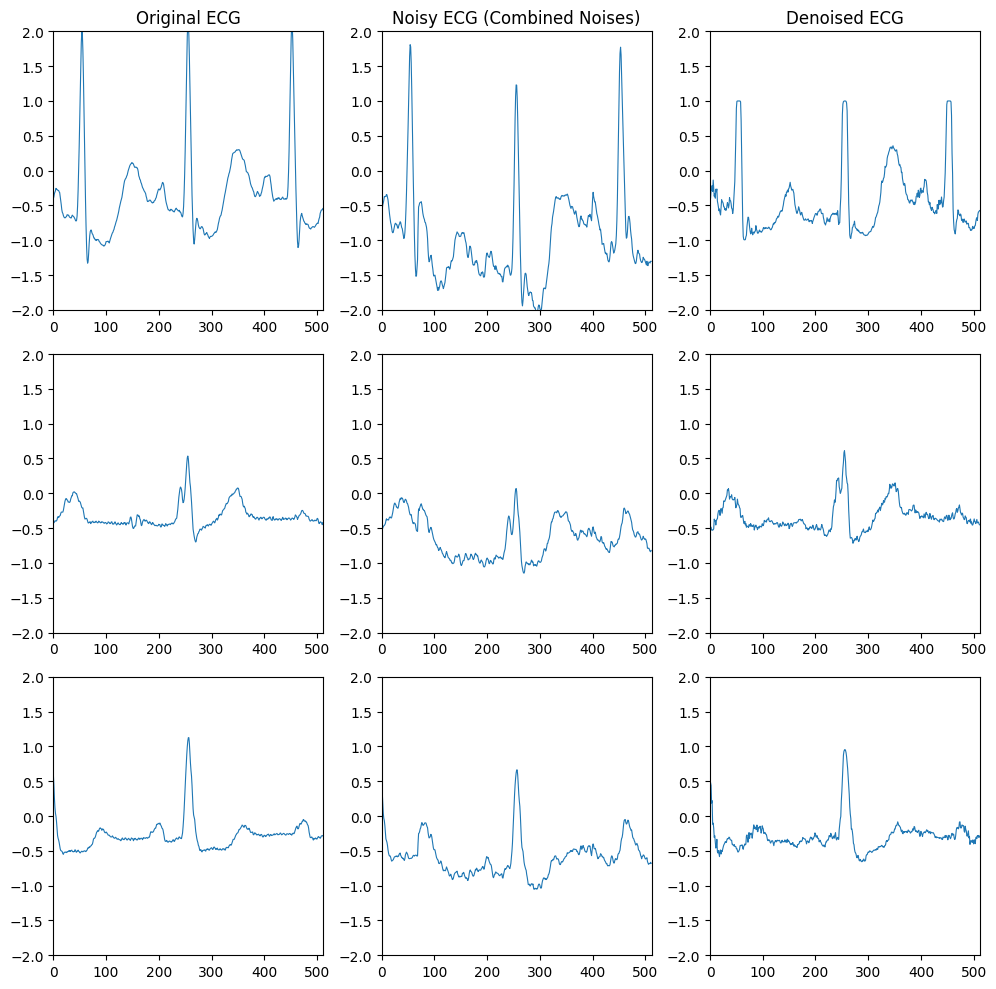

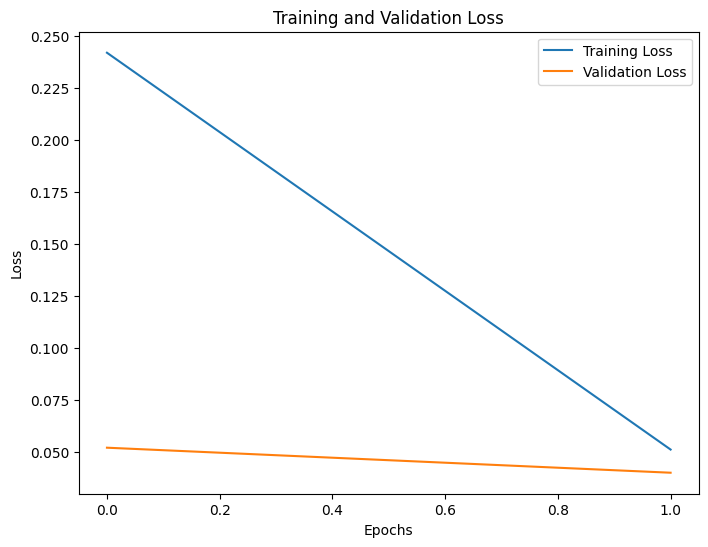

In [5]:
import wfdb
import numpy as np
import pywt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, LeakyReLU, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load ECG data with correct labels from the MIT-BIH Arrhythmia Database
def load_ecg_data_with_labels(record_numbers, segment_length=512):
    ecg_segments = []
    labels = []
    for rec_num in record_numbers:
        record = wfdb.rdrecord(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}')
        annotation = wfdb.rdann(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}', 'atr')
        
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - segment_length // 2)
            end = min(len(record.p_signal), start + segment_length)
            if end - start == segment_length:
                ecg_segments.append(record.p_signal[start:end, 0])  # Assuming MLII lead
                labels.append(annotation.symbol[i])
    
    return np.array(ecg_segments), np.array(labels)

# Load noise data from the correct directory and filenames
def load_noise_data():
    em = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\em', sampfrom=0).p_signal[:, 0]
    bw = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\bw', sampfrom=0).p_signal[:, 0]
    ma = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\ma', sampfrom=0).p_signal[:, 0]
    return em, bw, ma

# Instantiate the generator model with skip connections
def build_generator(input_shape=(512, 1)):
    inp = Input(shape=input_shape)

    # Encoder
    x1 = Conv1D(64, 15, padding='same', kernel_initializer='he_normal')(inp)
    x1 = LeakyReLU(negative_slope=0.2)(x1)

    x2 = Conv1D(128, 15, padding='same', kernel_initializer='he_normal')(x1)
    x2 = LeakyReLU(negative_slope=0.2)(x2)

    x3 = Conv1D(256, 15, padding='same', kernel_initializer='he_normal')(x2)
    x3 = LeakyReLU(negative_slope=0.2)(x3)

    x4 = Conv1D(512, 15, padding='same', kernel_initializer='he_normal')(x3)
    x4 = LeakyReLU(negative_slope=0.2)(x4)

    # Decoder with skip connections
    x5 = Conv1DTranspose(256, 15, padding='same', kernel_initializer='he_normal')(x4)
    x5 = LeakyReLU(negative_slope=0.2)(x5)
    x5 = Add()([x5, x3])

    x6 = Conv1DTranspose(128, 15, padding='same', kernel_initializer='he_normal')(x5)
    x6 = LeakyReLU(negative_slope=0.2)(x6)
    x6 = Add()([x6, x2])

    x7 = Conv1DTranspose(64, 15, padding='same', kernel_initializer='he_normal')(x6)
    x7 = LeakyReLU(negative_slope=0.2)(x7)
    x7 = Add()([x7, x1])

    out = Conv1DTranspose(1, 15, padding='same', activation='tanh')(x7)
    
    return Model(inp, out)

def denoise_signal(generator, noisy_signal):
    noisy_signal = np.expand_dims(noisy_signal, axis=-1)
    denoised_signal = generator.predict(noisy_signal)
    return denoised_signal.squeeze()

# Function to extract wavelet features
def extract_wavelet_features(ecg_slice):
    coeffs = pywt.wavedec(ecg_slice, 'db6', level=5)
    return coeffs[0]  # Using approximation coefficients at the highest level

# Function to classify heartbeats using SVM
def classify_heartbeats(features, labels):
    clf = SVC(kernel='linear', class_weight='balanced')
    clf.fit(features, labels)
    return clf

# Function to plot ECG signals
def plot_ecg_signals(noise_name, ecg_segments, noisy_ecg_slices, denoised_ecg_slices, num_samples=3):
    plt.figure(figsize=(10, 10))

    for i in range(num_samples):
        # Plot original ECG
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.plot(ecg_segments[i], linewidth=0.8)
        if i == 0:
            plt.title('Original ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(ecg_segments[i])])

        # Plot noisy ECG
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.plot(noisy_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title(f'Noisy ECG ({noise_name})')
        plt.ylim([-2, 2])
        plt.xlim([0, len(noisy_ecg_slices[i])])

        # Plot denoised ECG
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.plot(denoised_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title('Denoised ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(denoised_ecg_slices[i])])

    plt.tight_layout()
    plt.show()

generator = build_generator()
generator.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Load ECG and noise data
ecg_records = [103, 105, 111, 116, 122, 205, 213, 219, 223, 230]  # Add more records as needed
ecg_segments, labels = load_ecg_data_with_labels(ecg_records)
em_noise, bw_noise, ma_noise = load_noise_data()

# Filter and map labels to integer categories
label_mapping = {'N': 0, 'V': 1, 'A': 2, 'L': 3}
mapped_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = mapped_labels != -1

ecg_segments = ecg_segments[valid_indices]
mapped_labels = mapped_labels[valid_indices]

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(mapped_labels), y=mapped_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(ecg_segments, mapped_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Extend and add noise to ECG segments
def extend_noise_signal(noise_signal, target_length):
    repeated_noise = np.tile(noise_signal, int(np.ceil(target_length / len(noise_signal))))
    return repeated_noise[:target_length]

def calculate_snr(signal, noise):
    signal_power = np.sum(np.square(signal))
    noise_power = np.sum(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_rmse(signal, denoised_signal):
    return np.sqrt(np.mean((signal - denoised_signal) ** 2))

# Extend and add noise to ECG segments using the SNR formula
def add_noise_to_segments(ecg_segments, noise_signals, target_snr_db):
    noisy_segments = []
    combined_noise_signal = np.sum([extend_noise_signal(noise, ecg_segments.shape[1]) for noise in noise_signals], axis=0)
    
    for ecg_segment in ecg_segments:
        scaling_factor = np.sqrt(np.sum(np.square(ecg_segment)) / (np.sum(np.square(combined_noise_signal)) * 10**(target_snr_db / 10)))
        scaled_noise = combined_noise_signal[:len(ecg_segment)] * scaling_factor
        noisy_segment = ecg_segment + scaled_noise
        noisy_segments.append(noisy_segment)
    return np.array(noisy_segments)

# Combine all noise types for collective training
all_noises = [em_noise, bw_noise, ma_noise]

# Set the SNR value
snr_db = 0  # You can adjust this value based on your needs

# Create noisy training, validation, and test datasets using all noise types combined
noisy_ecg_slices_train = add_noise_to_segments(X_train, all_noises, snr_db)
noisy_ecg_slices_val = add_noise_to_segments(X_val, all_noises, snr_db)
noisy_ecg_slices_test = add_noise_to_segments(X_test, all_noises, snr_db)

# Expand dimensions for training and validation
noisy_ecg_slices_train_expanded = np.expand_dims(noisy_ecg_slices_train, axis=-1)  # Expand dims for the generator
noisy_ecg_slices_val_expanded = np.expand_dims(noisy_ecg_slices_val, axis=-1)  # Expand dims for validation
clean_ecg_segments_train_expanded = np.expand_dims(X_train, axis=-1)  # Expand dims for clean ECG training data
clean_ecg_segments_val_expanded = np.expand_dims(X_val, axis=-1)

# Train the generator model on the combined noise dataset
history = generator.fit(noisy_ecg_slices_train_expanded, clean_ecg_segments_train_expanded, 
              epochs=2, batch_size=32, validation_data=(noisy_ecg_slices_val_expanded, clean_ecg_segments_val_expanded))

# Denoise and classify after training
denoised_ecg_slices_test = denoise_signal(generator, noisy_ecg_slices_test)

# Calculate SNR and RMSE
snr_values = [calculate_snr(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
rmse_values = [calculate_rmse(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]

features_noisy = np.array([extract_wavelet_features(slice) for slice in noisy_ecg_slices_test])
features_denoised = np.array([extract_wavelet_features(slice) for slice in denoised_ecg_slices_test])

test_labels = y_test[:len(features_noisy)]

model_noisy = classify_heartbeats(features_noisy, test_labels)
model_denoised = classify_heartbeats(features_denoised, test_labels)

# Predict the classes
predictions_noisy = model_noisy.predict(features_noisy)
predictions_denoised = model_denoised.predict(features_denoised)

# Get the unique classes present in test_labels
unique_classes = np.unique(test_labels)
class_names = [name for i, name in enumerate(['N', 'V', 'A', 'L']) if i in unique_classes]

# Evaluate accuracy for each class
report_noisy = classification_report(test_labels, predictions_noisy, target_names=class_names, output_dict=True, zero_division=0)
report_denoised = classification_report(test_labels, predictions_denoised, target_names=class_names, output_dict=True, zero_division=0)

# Store accuracy and SNR, RMSE for each class
results = {
    'snr': np.mean(snr_values),
    'rmse': np.mean(rmse_values),
    'noisy': {class_name: report_noisy[class_name]['precision'] for class_name in class_names},
    'denoised': {class_name: report_denoised[class_name]['precision'] for class_name in class_names},
}

# Output the results
print(f"Average SNR after denoising: {results['snr']:.4f} dB")
print(f"Average RMSE after denoising: {results['rmse']:.4f}")
print("Noisy data accuracies:")
for class_label, accuracy in results['noisy'].items():
    print(f"  {class_label}: {accuracy:.4f}")
print("Denoised data accuracies:")
for class_label, accuracy in results['denoised'].items():
    print(f"  {class_label}: {accuracy:.4f}")
print("\n")

# Plotting for all noise types
plot_ecg_signals("Combined Noises", X_test, noisy_ecg_slices_test, denoised_ecg_slices_test)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.legend()
plt.show()


In [ ]:
import wfdb
import numpy as np
import pywt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, LeakyReLU, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load ECG data with correct labels from the MIT-BIH Arrhythmia Database
def load_ecg_data_with_labels(record_numbers, segment_length=512):
    ecg_segments = []
    labels = []
    for rec_num in record_numbers:
        record = wfdb.rdrecord(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}')
        annotation = wfdb.rdann(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}', 'atr')
        
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - segment_length // 2)
            end = min(len(record.p_signal), start + segment_length)
            if end - start == segment_length:
                ecg_segments.append(record.p_signal[start:end, 0])  # Assuming MLII lead
                labels.append(annotation.symbol[i])
    
    return np.array(ecg_segments), np.array(labels)

# Load noise data from the correct directory and filenames
def load_noise_data():
    em = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\em', sampfrom=0).p_signal[:, 0]
    bw = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\bw', sampfrom=0).p_signal[:, 0]
    ma = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\ma', sampfrom=0).p_signal[:, 0]
    return em, bw, ma

# Instantiate the generator model with skip connections
def build_generator(input_shape=(512, 1)):
    inp = Input(shape=input_shape)

    # Encoder
    x1 = Conv1D(64, 15, padding='same', kernel_initializer='he_normal')(inp)
    x1 = LeakyReLU(negative_slope=0.2)(x1)

    x2 = Conv1D(128, 15, padding='same', kernel_initializer='he_normal')(x1)
    x2 = LeakyReLU(negative_slope=0.2)(x2)

    x3 = Conv1D(256, 15, padding='same', kernel_initializer='he_normal')(x2)
    x3 = LeakyReLU(negative_slope=0.2)(x3)

    x4 = Conv1D(512, 15, padding='same', kernel_initializer='he_normal')(x3)
    x4 = LeakyReLU(negative_slope=0.2)(x4)

    # Decoder with skip connections
    x5 = Conv1DTranspose(256, 15, padding='same', kernel_initializer='he_normal')(x4)
    x5 = LeakyReLU(negative_slope=0.2)(x5)
    x5 = Add()([x5, x3])

    x6 = Conv1DTranspose(128, 15, padding='same', kernel_initializer='he_normal')(x5)
    x6 = LeakyReLU(negative_slope=0.2)(x6)
    x6 = Add()([x6, x2])

    x7 = Conv1DTranspose(64, 15, padding='same', kernel_initializer='he_normal')(x6)
    x7 = LeakyReLU(negative_slope=0.2)(x7)
    x7 = Add()([x7, x1])

    out = Conv1DTranspose(1, 15, padding='same', activation='tanh')(x7)
    
    return Model(inp, out)

def denoise_signal(generator, noisy_signal):
    noisy_signal = np.expand_dims(noisy_signal, axis=-1)
    denoised_signal = generator.predict(noisy_signal)
    return denoised_signal.squeeze()

# Function to extract wavelet features
def extract_wavelet_features(ecg_slice):
    coeffs = pywt.wavedec(ecg_slice, 'db6', level=5)
    return coeffs[0]  # Using approximation coefficients at the highest level

# Function to classify heartbeats using SVM
def classify_heartbeats(features, labels):
    clf = SVC(kernel='linear', class_weight='balanced')
    clf.fit(features, labels)
    return clf

# Function to plot ECG signals
def plot_ecg_signals(noise_name, ecg_segments, noisy_ecg_slices, denoised_ecg_slices, num_samples=3):
    plt.figure(figsize=(10, 10))

    for i in range(num_samples):
        # Plot original ECG
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.plot(ecg_segments[i], linewidth=0.8)
        if i == 0:
            plt.title('Original ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(ecg_segments[i])])

        # Plot noisy ECG
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.plot(noisy_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title(f'Noisy ECG ({noise_name})')
        plt.ylim([-2, 2])
        plt.xlim([0, len(noisy_ecg_slices[i])])

        # Plot denoised ECG
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.plot(denoised_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title('Denoised ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(denoised_ecg_slices[i])])

    plt.tight_layout()
    plt.show()

generator = build_generator()
generator.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Load ECG and noise data
ecg_records = [103, 105, 111, 116, 122, 205, 213, 219, 223, 230]  # Add more records as needed
ecg_segments, labels = load_ecg_data_with_labels(ecg_records)
em_noise, bw_noise, ma_noise = load_noise_data()

# Filter and map labels to integer categories
label_mapping = {'N': 0, 'V': 1, 'A': 2, 'L': 3}
mapped_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = mapped_labels != -1

ecg_segments = ecg_segments[valid_indices]
mapped_labels = mapped_labels[valid_indices]

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(mapped_labels), y=mapped_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(ecg_segments, mapped_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Extend and add noise to ECG segments
def extend_noise_signal(noise_signal, target_length):
    repeated_noise = np.tile(noise_signal, int(np.ceil(target_length / len(noise_signal))))
    return repeated_noise[:target_length]

def calculate_snr(signal, noise):
    signal_power = np.sum(np.square(signal))
    noise_power = np.sum(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_rmse(signal, denoised_signal):
    return np.sqrt(np.mean((signal - denoised_signal) ** 2))

# Extend and add noise to ECG segments using the SNR formula
def add_noise_to_segments(ecg_segments, noise_signal, target_snr_db):
    noisy_segments = []
    noise_signal = extend_noise_signal(noise_signal, ecg_segments.shape[1])
    
    for ecg_segment in ecg_segments:
        scaling_factor = np.sqrt(np.sum(np.square(ecg_segment)) / (np.sum(np.square(noise_signal)) * 10**(target_snr_db / 10)))
        scaled_noise = noise_signal[:len(ecg_segment)] * scaling_factor
        noisy_segment = ecg_segment + scaled_noise
        noisy_segments.append(noisy_segment)
    return np.array(noisy_segments)

# Dictionary to hold the noise data and names
noises = {
    'EM': em_noise,
    'BW': bw_noise,
    'MA': ma_noise,
    'Combined': em_noise + bw_noise + ma_noise
}

# Loop over each noise type to train and generate plots
for noise_name, noise_signal in noises.items():
    print(f"Processing noise type: {noise_name}")

    # Generate noisy data for the current noise type
    noisy_ecg_slices_train = add_noise_to_segments(X_train, noise_signal, snr_db)
    noisy_ecg_slices_val = add_noise_to_segments(X_val, noise_signal, snr_db)
    noisy_ecg_slices_test = add_noise_to_segments(X_test, noise_signal, snr_db)

    # Expand dimensions for training and validation
    noisy_ecg_slices_train_expanded = np.expand_dims(noisy_ecg_slices_train, axis=-1)  # Expand dims for the generator
    noisy_ecg_slices_val_expanded = np.expand_dims(noisy_ecg_slices_val, axis=-1)  # Expand dims for validation
    clean_ecg_segments_train_expanded = np.expand_dims(X_train, axis=-1)  # Expand dims for clean ECG training data
    clean_ecg_segments_val_expanded = np.expand_dims(X_val, axis=-1)

    # Train the generator model on the current noise dataset
    history = generator.fit(noisy_ecg_slices_train_expanded, clean_ecg_segments_train_expanded, 
                            epochs=2, batch_size=32, validation_data=(noisy_ecg_slices_val_expanded, clean_ecg_segments_val_expanded))

    # Denoise and classify after training
    denoised_ecg_slices_test = denoise_signal(generator, noisy_ecg_slices_test)

    # Calculate SNR and RMSE
    snr_values = [calculate_snr(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
    rmse_values = [calculate_rmse(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]

    features_noisy = np.array([extract_wavelet_features(slice) for slice in noisy_ecg_slices_test])
    features_denoised = np.array([extract_wavelet_features(slice) for slice in denoised_ecg_slices_test])

    test_labels = y_test[:len(features_noisy)]

    model_noisy = classify_heartbeats(features_noisy, test_labels)
    model_denoised = classify_heartbeats(features_denoised, test_labels)

    # Predict the classes
    predictions_noisy = model_noisy.predict(features_noisy)
    predictions_denoised = model_denoised.predict(features_denoised)

    # Get the unique classes present in test_labels
    unique_classes = np.unique(test_labels)
    class_names = [name for i, name in enumerate(['N', 'V', 'A', 'L']) if i in unique_classes]

    # Evaluate accuracy for each class
    report_noisy = classification_report(test_labels, predictions_noisy, target_names=class_names, output_dict=True, zero_division=0)
    report_denoised = classification_report(test_labels, predictions_denoised, target_names=class_names, output_dict=True, zero_division=0)

    # Store accuracy and SNR, RMSE for each class
    results = {
        'snr': np.mean(snr_values),
        'rmse': np.mean(rmse_values),
        'noisy': {class_name: report_noisy[class_name]['precision'] for class_name in class_names},
        'denoised': {class_name: report_denoised[class_name]['precision'] for class_name in class_names},
    }

    # Output the results for the current noise type
    print(f"Average SNR after denoising: {results['snr']:.4f} dB")
    print(f"Average RMSE after denoising: {results['rmse']:.4f}")
    print("Noisy data accuracies:")
    for class_label, accuracy in results['noisy'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("Denoised data accuracies:")
    for class_label, accuracy in results['denoised'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("\n")

    # Plotting for the current noise type
    plot_ecg_signals(noise_name, X_test, noisy_ecg_slices_test, denoised_ecg_slices_test)

    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss ({noise_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss') 
    plt.legend()
    plt.show()


Processing noise type: EM
Epoch 1/2
529/529 ━━━━━━━━━━━━━━━━━━━━ 496s 936ms/step - loss: 0.1919 - val_loss: 0.0370
Epoch 2/2
164/529 ━━━━━━━━━━━━━━━━━━━━ 5:31 907ms/step - loss: 0.0371